<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/03_TextImage/examples/Workshop4_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this workshop, we will train a logo generator using a Generative Adversarial Network.

If you don't have a GPU, you should try this on Google Colab for best results.

## Dataset

Large Logo Dataset (LLD), a dataset of 600k+ logos crawled from the internet.

https://data.vision.ee.ethz.ch/sagea/lld/

The dataset consists of two parts, crawled from the the Alexa 1M websites list:

- LLD-icon: 548,210 standardized 32 x 32-pixel favicons, crawled on April 7th 2017
- LLD-logo: 122,920 high-resolution (mostly 400 x 400 pixels) logos gathered from twitter on August 17th 2017

We will use the LLD-icon sample dataset of 5000 favicons. This has been downloaded for you.

In [2]:
# if running on Google Colab, upload the zip file, unzip, then move it to a subfolder
# !unzip LLD-icon_sample.zip
# !mkdir LLD-icon_sample
# !mv 5klogos LLD-icon_sample

Streaming output truncated to the last 5000 lines.
 extracting: 5klogos/010795.png      
 extracting: 5klogos/354436.png      
 extracting: 5klogos/366798.png      
 extracting: 5klogos/210870.png      
 extracting: 5klogos/258736.png      
 extracting: 5klogos/467023.png      
 extracting: 5klogos/443887.png      
 extracting: 5klogos/299645.png      
 extracting: 5klogos/056629.png      
 extracting: 5klogos/398481.png      
 extracting: 5klogos/009279.png      
 extracting: 5klogos/067100.png      
 extracting: 5klogos/287732.png      
 extracting: 5klogos/440142.png      
 extracting: 5klogos/037562.png      
 extracting: 5klogos/133179.png      
 extracting: 5klogos/131517.png      
 extracting: 5klogos/310866.png      
 extracting: 5klogos/291274.png      
 extracting: 5klogos/404231.png      
 extracting: 5klogos/116364.png      
 extracting: 5klogos/234018.png      
 extracting: 5klogos/460705.png      
 extracting: 5klogos/220059.png      
 extracting: 5klogos/322035.png      

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [4]:
# load the images
batch_size = 32
image_size = (32, 32)
image_shape = (32, 32, 3)

# pre-processing: scale images from -1 to 1 (best practice for GAN)
def scale_image(image):
    return (image - 127)/255

# no augmentation needed, our dataset is large
train_datagen = ImageDataGenerator(preprocessing_function=scale_image)

# even for class_mode None (no labels), data still needs to reside in a subdirectory of directory
X_train = train_datagen.flow_from_directory('./LLD-icon_sample', 
                                            target_size=image_size, batch_size=batch_size,
                                            class_mode=None)

Found 4999 images belonging to 1 classes.


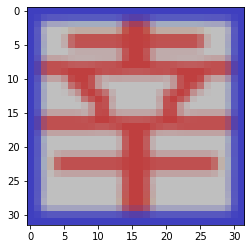

In [5]:
# inspect an image
batch = next(X_train)

# scale from [-1,1] to [0,1] which is what matplotlib expects
plt.imshow((batch[0] + 1.)/2.)
plt.show()

## Deep Convolutional GAN

We'll use a similar architecture as described here: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

It follows most of these best practices (https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/). 

A summary of the *empirical* best practices to get stable GAN results (note: not all are adopted in this workshop):
- Normalize inputs to the range [-1, 1] and use tanh in the generator output.
- Flip the labels and loss function when training the generator.
- Sample Gaussian random numbers as input to the generator.
- Add noise to inputs to the discriminator and decay the noise over time.
- Use mini batches of all real or all fake for calculating batch norm statistics.
- Use Leaky ReLU in the generator and discriminator. Use Leaky ReLU in the discriminator with a slope of 0.2.
- Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.
- Use label smoothing in the discriminator, with small random noise.
- Add random noise to the labels in the discriminator.
- Use DCGAN architecture, unless you have a good reason not to. (https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-the-Generator-Model-Architecture-for-the-DCGAN.png)
- Use labels if you have them.
- Use dropout of 50 percent during train and generation.
- Use the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum (beta1) of 0.5.
- A loss of 0.0 in the discriminator is a failure mode.
- If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.

## Discriminator

- Inputs: Image with three color channel and 32×32 pixels in size.
- Outputs: Binary classification, likelihood the sample is real (or fake).

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [7]:
def define_discriminator(input_shape):
    model_input = Input(shape=input_shape)
 
    x = Conv2D(64, kernel_size=(3,3), strides=1, padding='same', activation=LeakyReLU(alpha=0.2))(model_input)
    
    # downsampling without pooling (use strides=2)
    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(128, kernel_size=(3,3), strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = Conv2D(256, kernel_size=(3,3), strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    
    # mlp binary classifier
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(model_input, x)
    
    # compile
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
    return model

In [8]:
model_dis = define_discriminator(input_shape=image_shape)
model_dis.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)             

In [9]:
# function to get fake samples with label=0
def generate_fake_samples(n_samples, input_shape):
    X = np.random.rand(input_shape[0]*input_shape[1]*input_shape[2]*n_samples)
    
    X = -1. + X * 2. # scale to [-1,1]
    X = X.reshape(n_samples, *input_shape) # reshape
    
    y = np.zeros((n_samples, 1))
    return X, y

# test
generate_fake_samples(5, input_shape=image_shape)

(array([[[[-0.26472546,  0.78992809, -0.8325861 ],
          [-0.54501874,  0.84368284, -0.33140505],
          [ 0.62026179, -0.56236472,  0.80203778],
          ...,
          [ 0.95091868,  0.11902519,  0.42731984],
          [-0.23903181, -0.97812236, -0.48326871],
          [ 0.09577209,  0.05038857,  0.80495513]],
 
         [[ 0.52213888,  0.29584176, -0.76678248],
          [-0.96755326, -0.52293302,  0.43417881],
          [ 0.25483927, -0.75113998, -0.67961062],
          ...,
          [-0.01612576,  0.90242121,  0.78472663],
          [-0.58391105,  0.89179164,  0.13306814],
          [-0.75257088, -0.76346387,  0.68384449]],
 
         [[ 0.25660811, -0.71435641,  0.84467582],
          [-0.02599616,  0.28764135, -0.66596599],
          [-0.91645537,  0.60461494, -0.18894741],
          ...,
          [-0.63610815,  0.84470195, -0.16462978],
          [-0.47362125,  0.8558139 , -0.60959995],
          [-0.83988715, -0.05644903,  0.83379012]],
 
         ...,
 
         [[ 

In [10]:
# function to get real samples with label=1
def generate_real_samples(n_samples, dataset_generator):
    batch = next(dataset_generator)
    if (len(batch) < n_samples):
        dataset_generator.reset()
        batch = next(dataset_generator)
    
    X = batch[:n_samples]
    y = np.ones((n_samples, 1))
    return X, y

# test
generate_real_samples(5, X_train)

(array([[[[ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          ...,
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ]],
 
         [[ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          ...,
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ],
          [ 0.5019608 ,  0.5019608 ,  0.5019608 ]],
 
         [[ 0.49803922,  0.49803922,  0.49803922],
          [ 0.49803922,  0.49803922,  0.49803922],
          [ 0.49803922,  0.49803922,  0.49803922],
          ...,
          [ 0.49411765,  0.49411765,  0.49411765],
          [ 0.49803922,  0.49803922,  0.49803922],
          [ 0.49803922,  0.49803922,  0.49803922]],
 
         ...,
 
         [[ 

In [11]:
# function to train the discriminator model
def train_discriminator(model, dataset_generator, n_iter=20, n_batch=64):
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(half_batch, dataset_generator)
        
        # update discriminator on real samples, returns: loss (unused), accuracy
        _, real_acc = model.train_on_batch(X_real, y_real)
        
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch, input_shape=X_real.shape[1:])

        # update discriminator on fake samples, returns: loss (unused), accuracy
        _, fake_acc = model.train_on_batch(X_fake, y_fake)

        # summarize accuracies on discriminating real vs. fake
        print(f'epoch {i+1}: accuracy real={real_acc*100:.2f}% fake={fake_acc*100:.2f}%')

# test
model_dis = define_discriminator(input_shape=image_shape)
train_discriminator(model_dis, X_train)

epoch 1: accuracy real=65.62% fake=0.00%
epoch 2: accuracy real=100.00% fake=9.38%
epoch 3: accuracy real=84.38% fake=31.25%
epoch 4: accuracy real=87.50% fake=78.12%
epoch 5: accuracy real=81.25% fake=100.00%
epoch 6: accuracy real=75.00% fake=100.00%
epoch 7: accuracy real=84.38% fake=100.00%
epoch 8: accuracy real=68.75% fake=100.00%
epoch 9: accuracy real=87.50% fake=100.00%
epoch 10: accuracy real=71.88% fake=100.00%
epoch 11: accuracy real=78.12% fake=100.00%
epoch 12: accuracy real=81.25% fake=100.00%
epoch 13: accuracy real=90.62% fake=100.00%
epoch 14: accuracy real=75.00% fake=100.00%
epoch 15: accuracy real=84.38% fake=100.00%
epoch 16: accuracy real=87.50% fake=100.00%
epoch 17: accuracy real=87.50% fake=100.00%
epoch 18: accuracy real=84.38% fake=100.00%
epoch 19: accuracy real=90.62% fake=100.00%
epoch 20: accuracy real=90.62% fake=100.00%


## Generator

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

In [12]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

In [13]:
# define the standalone generator model
def define_generator(latent_dim):
    model_input = Input(shape=latent_dim)
    
    # start with 4x4 image, 256 channels
    x = Dense(256*4*4, activation=LeakyReLU(alpha=0.2))(model_input)
    x = Reshape((4, 4, 256))(x)
    
    # upsample to 8x8
    x = Conv2DTranspose(128, kernel_size=(4,4), strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    # upsample to 16x16
    x = Conv2DTranspose(128, kernel_size=(4,4), strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)
    # upsample to 32x32
    x = Conv2DTranspose(128, kernel_size=(4,4), strides=2, padding='same', activation=LeakyReLU(alpha=0.2))(x)

    # output
    x = Conv2D(3, kernel_size=(3,3), activation='tanh', padding='same')(x)
    
    model = Model(model_input, x)
    return model

# test
model_gen = define_generator(latent_dim=100)
model_gen.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 3)        

In [14]:
# function to generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    return x_input.reshape(n_samples, latent_dim)

# test
generate_latent_points(100, 5)

array([[-1.57943102e+00, -6.93581621e-01, -1.05060565e+00,
        -5.90367377e-01,  2.41418060e+00, -4.33174443e-01,
         6.57981722e-01,  1.30680770e+00, -3.88202079e-02,
        -3.24005829e-01,  7.67788265e-01, -1.72434549e+00,
        -7.84900358e-01,  2.38444018e-01,  4.37101782e-01,
        -4.42483283e-01, -3.26327647e-01, -1.45641946e-02,
         1.21497720e-01, -7.32235386e-01, -2.08834422e+00,
        -1.45694351e+00,  6.14837469e-01,  5.93502280e-02,
         7.39460039e-02,  5.20488832e-01,  3.29077399e+00,
         1.47338031e+00,  4.78407937e-01, -2.14388117e-01,
        -5.73307045e-01,  1.85617638e-01,  8.65209308e-01,
         1.01402126e+00, -1.22110986e+00, -3.90027618e-01,
         6.84434700e-01, -9.25249161e-01, -1.02276373e+00,
         1.01067715e+00,  1.40031140e+00,  2.71658874e-01,
        -1.01101977e+00,  3.10099427e-01,  3.81696796e-01,
        -1.42766506e+00,  8.87386272e-01,  1.22782918e+00,
         2.36262935e-01, -1.59903783e+00, -4.39513707e-0

In [15]:
# update the fake samples generator to use the generator model
def generate_fake_samples(generator_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)

    # use the generator model to generate an image from the latent points
    X = generator_model.predict(x_input)

    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# test
model_gen = define_generator(latent_dim=100)
generate_fake_samples(model_gen, 100, 5)

(array([[[[-1.02726358e-03, -1.81940000e-03, -2.20435904e-03],
          [-4.36997943e-04,  4.28085309e-03, -2.30842433e-03],
          [-1.73513708e-03, -5.62071754e-03,  6.38964528e-04],
          ...,
          [-4.29810444e-03,  1.25436094e-02, -5.91986487e-03],
          [-8.31809186e-04,  2.77041108e-03,  1.54583168e-03],
          [-2.78267707e-03,  3.17277876e-03, -6.71541784e-06]],
 
         [[ 1.12741545e-03,  6.17977185e-03, -3.90368910e-03],
          [ 7.97940011e-04, -4.98906523e-03, -1.25024852e-03],
          [-5.68934192e-04,  6.97754277e-03,  1.67108455e-03],
          ...,
          [-7.43549643e-03,  8.94699618e-03, -2.10341881e-03],
          [ 1.65795453e-03, -1.13040442e-03, -1.24728843e-03],
          [ 4.85260942e-04,  2.39459891e-03,  6.15401892e-03]],
 
         [[-6.61015802e-04, -4.71609132e-03,  5.99228253e-04],
          [-4.10383148e-03, -1.00950617e-03, -8.70468444e-04],
          [-1.57124810e-02,  1.50864595e-03,  1.68248010e-03],
          ...,
    

## DCGAN

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Generator: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].
- Discriminator (Output): Binary classification, likelihood the sample is real (or fake).

In [16]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    # start with the generator
    model_input = g_model.input

    # connect output of generator to input of discriminator
    x = d_model(g_model.output)
    
    # use output of discriminator as the model output
    model = Model(g_model.input, x)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# test
model_gen = define_generator(latent_dim=100)
model_dis = define_discriminator(input_shape=image_shape)
gan = define_gan(model_gen, model_dis)
gan.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 3)       

In [17]:
def evaluate(epoch, g_model, d_model, dataset, latent_dim, n_samples=10):
    # prepare real samples
    X_real, y_real = generate_real_samples(n_samples, dataset)

    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)    

    # summarize discriminator performance
    print(f'>Accuracy real: {acc_real*100:.2f}%, fake: {acc_fake*100:.2f}%')

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim,
          n_epochs=50, n_batch=64, batches_per_epoch=10):

    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(batches_per_epoch):

            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(half_batch, dataset)

            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)            

            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss0, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)            
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(x_gan, y_gan)
            
            # summarize loss on this batch
            print(f'>{i+1} ({j+1}/{batches_per_epoch}): d_loss1={d_loss1:.3f}, d_loss0={d_loss0:.3f} g_loss={g_loss:.3f}')
            
        # evaluate the model performance, once in a while
        if (i+1) % 10 == 0:
            evaluate(i, g_model, d_model, dataset, latent_dim)

            # we manually save the model (instead of ModelCheckpoint) because we are training on batch
            # (the discriminator is discarded)
            g_model.save(f'g_model_e{i+1}.h5')
            save_plot(X_fake, i)
            
# test everything before we have to actually train
model_gen = define_generator(latent_dim=100)
model_dis = define_discriminator(input_shape=image_shape)
gan = define_gan(model_gen, model_dis)

train(model_gen, model_dis, gan, X_train, latent_dim=100, n_epochs=1, n_batch=64, batches_per_epoch=5)
evaluate(0, model_gen, model_dis, X_train, latent_dim=100, n_samples=16)

>1 (1/5): d_loss1=0.690, d_loss0=0.695 g_loss=0.692
>1 (2/5): d_loss1=0.632, d_loss0=0.698 g_loss=0.689
>1 (3/5): d_loss1=0.578, d_loss0=0.705 g_loss=0.682
>1 (4/5): d_loss1=0.521, d_loss0=0.723 g_loss=0.665
>1 (5/5): d_loss1=0.413, d_loss0=0.768 g_loss=0.629
>Accuracy real: 100.00%, fake: 0.00%


In [18]:
# create and save a plot of generated images
def save_plot(examples, epoch, rows=4):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0

    # plot images
    for i in range(rows * rows):
        plt.subplot(rows, rows, 1 + i)
        plt.axis('off')
        
        # plot raw pixel data
        plt.imshow(examples[i])

    plt.savefig(f'generated_plot_e{epoch+1}.png')
    plt.close()

examples, _ = generate_fake_samples(model_gen, 100, 16)
save_plot(examples, 0, rows=4)

Genreated logos after running once (grey because we are still generating random noise):

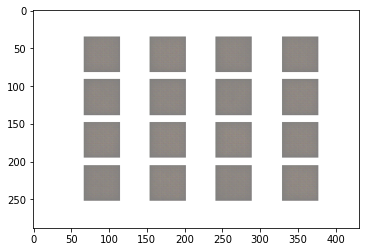

In [20]:
from tensorflow.keras.preprocessing.image import load_img

plt.imshow(load_img('./generated_plot_e1.png'))
plt.show()

In [21]:
# finally....training
model_gen = define_generator(latent_dim=100)
model_dis = define_discriminator(input_shape=image_shape)
gan = define_gan(model_gen, model_dis)

In [22]:
train(model_gen, model_dis, gan, X_train, latent_dim=100, n_epochs=200, n_batch=64, batches_per_epoch=10)

>1 (1/10): d_loss1=0.681, d_loss0=0.697 g_loss=0.690
>1 (2/10): d_loss1=0.628, d_loss0=0.701 g_loss=0.686
>1 (3/10): d_loss1=0.598, d_loss0=0.709 g_loss=0.677
>1 (4/10): d_loss1=0.522, d_loss0=0.732 g_loss=0.657
>1 (5/10): d_loss1=0.435, d_loss0=0.786 g_loss=0.618
>1 (6/10): d_loss1=0.358, d_loss0=0.881 g_loss=0.576
>1 (7/10): d_loss1=0.304, d_loss0=0.959 g_loss=0.559
>1 (8/10): d_loss1=0.273, d_loss0=0.971 g_loss=0.592
>1 (9/10): d_loss1=0.290, d_loss0=0.845 g_loss=0.670
>1 (10/10): d_loss1=0.325, d_loss0=0.761 g_loss=0.770
>2 (1/10): d_loss1=0.295, d_loss0=0.666 g_loss=0.885
>2 (2/10): d_loss1=0.343, d_loss0=0.618 g_loss=0.960
>2 (3/10): d_loss1=0.241, d_loss0=0.563 g_loss=0.990
>2 (4/10): d_loss1=0.369, d_loss0=0.584 g_loss=0.916
>2 (5/10): d_loss1=0.237, d_loss0=0.603 g_loss=0.857
>2 (6/10): d_loss1=0.203, d_loss0=0.625 g_loss=0.810
>2 (7/10): d_loss1=0.193, d_loss0=0.657 g_loss=0.775
>2 (8/10): d_loss1=0.167, d_loss0=0.685 g_loss=0.755
>2 (9/10): d_loss1=0.178, d_loss0=0.720 g_los